In [1]:
import time
from google.cloud import documentai_v1beta3 as documentai
from google.api_core.client_options import ClientOptions
from google.protobuf import field_mask_pb2
from google.protobuf.json_format import MessageToJson
import json


In [2]:
# --------------- CONFIGURATION -------------------
PROJECT_ID = "prj-app-wh-dev"
LOCATION = "us"  # or "eu" depending on your processor location

PROCESSOR_ID = 'd56c0a005c7ca504'



**Create Processor**

In [ ]:
def create_processor(client, display_name):
    parent = f"projects/{PROJECT_ID}/locations/{LOCATION}"
    processor = documentai.Processor(
        type_="CUSTOM_EXTRACTION_PROCESSOR",  # Very important
        display_name=display_name,
    )
    response = client.create_processor(parent=parent, processor=processor)
    print(f"Processor created: {response.name}")
    return response.name


client = documentai.DocumentProcessorServiceClient()
processor_name = create_processor(client, display_name="automation_test_processor")
processor_id = processor_name.split("/")[-1]



**Initialize Dataset**

In [3]:

gcs_uri_prefix = "gs://prj-app-wh-dev-backend-data/docai_dataset/"

# Setup the endpoint correctly
client_options = ClientOptions(api_endpoint=f"{LOCATION}-documentai.googleapis.com")

# Initialize the Document AI client
client = documentai.DocumentServiceAsyncClient(client_options=client_options)

# Build the full dataset resource name
dataset_name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}/dataset"

# Prepare the dataset configuration
dataset = documentai.Dataset(
    name=dataset_name,
    gcs_managed_config=documentai.Dataset.GCSManagedConfig(
        gcs_prefix=documentai.GcsPrefix(
            gcs_uri_prefix=gcs_uri_prefix
        )
    ),
    spanner_indexing_config=documentai.Dataset.SpannerIndexingConfig()
)

# Prepare the update request
update_request = documentai.UpdateDatasetRequest(
    dataset=dataset
)

# Call the update_dataset API
operation = client.update_dataset(request=update_request)

response = (await operation).result()



**Create Schema**

In [4]:

# ✅ Use the DocumentServiceClient
client = documentai.DocumentServiceClient()

# Dataset name
dataset_name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}/dataset"
dataset_schema_name = f"{dataset_name}/datasetSchema"

# Define the schema fields with all data types
properties_list = [
    documentai.DocumentSchema.EntityType.Property(
        name="invoice_number",
        display_name="Invoice Number",
        value_type="string",  # Plain text
        occurrence_type=documentai.DocumentSchema.EntityType.Property.OccurrenceType.OPTIONAL_ONCE,
    ),
    documentai.DocumentSchema.EntityType.Property(
        name="item_count",
        display_name="Item Count",
        value_type="number",  # Number
        occurrence_type=documentai.DocumentSchema.EntityType.Property.OccurrenceType.OPTIONAL_ONCE,
    ),
    documentai.DocumentSchema.EntityType.Property(
        name="total_amount",
        display_name="Total Amount",
        value_type="currency",  # Currency
        occurrence_type=documentai.DocumentSchema.EntityType.Property.OccurrenceType.OPTIONAL_ONCE,
    ),
    documentai.DocumentSchema.EntityType.Property(
        name="line_item_amount",
        display_name="Line Item Amount",
        value_type="money",  # Money
        occurrence_type=documentai.DocumentSchema.EntityType.Property.OccurrenceType.OPTIONAL_MULTIPLE,
    ),
    documentai.DocumentSchema.EntityType.Property(
        name="invoice_date",
        display_name="Invoice Date",
        value_type="datetime",  # Datetime
        occurrence_type=documentai.DocumentSchema.EntityType.Property.OccurrenceType.REQUIRED_ONCE,
    ),
    documentai.DocumentSchema.EntityType.Property(
        name="billing_address",
        display_name="Billing Address",
        value_type="address",  # Address
        occurrence_type=documentai.DocumentSchema.EntityType.Property.OccurrenceType.OPTIONAL_ONCE,
    ),
    # documentai.DocumentSchema.EntityType.Property(
    #     name="is_paid",
    #     display_name="Is Paid",
    #     value_type="boolean",  # Checkbox
    #     occurrence_type=documentai.DocumentSchema.EntityType.Property.OccurrenceType.OPTIONAL_ONCE,
    # ),
]

# Create the DocumentSchema - ✅ name must be 'custom_extraction_document_type'
document_schema = documentai.DocumentSchema(
    display_name="Invoice Schema (All Data Types)",
    description="Schema demonstrating all supported data types",
    entity_types=[
        documentai.DocumentSchema.EntityType(
            display_name="Invoice",
            name="custom_extraction_document_type",
            description="Root type for invoice fields",
            base_types=["document"],
            properties=properties_list
        )
    ]
)

# Build the dataset schema
dataset_schema = documentai.DatasetSchema(
    name=dataset_schema_name,
    document_schema=document_schema
)

# Prepare the request
update_schema_request = documentai.UpdateDatasetSchemaRequest(
    dataset_schema=dataset_schema,
    update_mask=field_mask_pb2.FieldMask(paths=["document_schema"])
)

# ✅ Update the dataset schema using DocumentServiceClient
response = client.update_dataset_schema(request=update_schema_request)
print("✅ Dataset schema updated with all data types:", response)


✅ Dataset schema updated with all data types: name: "projects/prj-app-wh-dev/locations/us/processors/d56c0a005c7ca504/dataset/datasetSchema"
document_schema {
  display_name: "Invoice Schema (All Data Types)"
  description: "Schema demonstrating all supported data types"
  entity_types {
    name: "custom_extraction_document_type"
    base_types: "document"
    properties {
      name: "invoice_number"
      value_type: "string"
      occurrence_type: OPTIONAL_ONCE
      property_metadata {
      }
      display_name: "Invoice Number"
    }
    properties {
      name: "item_count"
      value_type: "number"
      occurrence_type: OPTIONAL_ONCE
      property_metadata {
      }
      display_name: "Item Count"
    }
    properties {
      name: "total_amount"
      value_type: "currency"
      occurrence_type: OPTIONAL_ONCE
      property_metadata {
      }
      display_name: "Total Amount"
    }
    properties {
      name: "line_item_amount"
      value_type: "money"
      occurrenc

/tmp/ipykernel_441794/2384809088.py:82: RuntimeWarning: coroutine 'AsyncFuture.result' was never awaited
  response = client.update_dataset_schema(request=update_schema_request)


**Initial parsing of samples by Document AI pretrained model for JSON creation**

In [ ]:

client = documentai.DocumentProcessorServiceClient()

name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}"

gcs_input_uri = "gs://prj-app-wh-dev-backend-data/docai_samples/invoice5.pdf"

# ✅ Just one GcsDocument directly
gcs_document = documentai.GcsDocument(
    gcs_uri=gcs_input_uri,
    mime_type="application/pdf"
)

# ✅ Create the request (note we now use gcs_document ✅)
request = documentai.ProcessRequest(
    name=name,
    skip_human_review=True,
    gcs_document=gcs_document
)




# 🚀 Process the document
result = client.process_document(request=request)
print("✅ Processed document:", result.document)

print(type(result.document))


# ✅ Access the internal protobuf directly
document_proto = result._pb.document

# ✅ Convert to JSON string
document_json_str = MessageToJson(document_proto)

# ✅ Save to file
with open("invoice5.json", "w") as f:
    json.dump(json.loads(document_json_str), f, indent=2)

print("✅ Saved JSON to invoice3.json")


✅ Processed document: uri: ""
mime_type: "application/pdf"
text: "Invoicing templates\nThis invoice template can be used to bill your clients in order to collect payments. This template\ncontains the basic information typically contained in an invoice such as the invoice amount, the\nservices/products provided and the payment due date. Follow the instructions contained in the\ntemplate and review the second page for a filled out example. This document is ideal for small\nbusinesses that want to invoice clients and receive timely payments.\n\340\271\200\340\270\227\305\244\340\270\231\340\271\200\305\244\nquickbooks\nAll information and forms are provided \"as is\" without any warranty of any kind, express, implied or otherwise, including as to their legal\neffect and completeness. They are for general guidance and should be modified by you or your attorney to meet your specific needs and\nthe laws of your state. Use at your own risk. Intuit, its employees or contractors who wrote or mo

**Import documents in DocAI processor**

In [ ]:

# Set your regional endpoint
client_options = ClientOptions(api_endpoint=f"{LOCATION}-documentai.googleapis.com")
client = documentai.DocumentServiceClient(client_options=client_options)

dataset_name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}/dataset"

# Define the documents to import
gcs_documents = documentai.GcsDocuments(
    documents=[
        documentai.GcsDocument(
            gcs_uri="gs://prj-app-wh-dev-backend-data/docai_samples/invoice55.json",
            mime_type="application/json"
        ),

        documentai.GcsDocument(
            gcs_uri="gs://prj-app-wh-dev-backend-data/docai_samples/invoice44.json",
            mime_type="application/json"
        ),

        documentai.GcsDocument(
            gcs_uri="gs://prj-app-wh-dev-backend-data/docai_samples/invoice33.json",
            mime_type="application/json"
        ),

        documentai.GcsDocument(
            gcs_uri="gs://prj-app-wh-dev-backend-data/docai_samples/invoice22.json",
            mime_type="application/json"
        ),

        documentai.GcsDocument(
            gcs_uri="gs://prj-app-wh-dev-backend-data/docai_samples/invoice11.json",
            mime_type="application/json"
        ),
    ]
)

batch_input_config = documentai.BatchDocumentsInputConfig(
    gcs_documents=gcs_documents
)

batch_import_config = documentai.ImportDocumentsRequest.BatchDocumentsImportConfig(
    batch_input_config=batch_input_config,
    dataset_split=documentai.DatasetSplitType.DATASET_SPLIT_TEST
)

request = documentai.ImportDocumentsRequest(
    dataset=dataset_name,
    batch_documents_import_configs=[batch_import_config]
)

# Start the import
print("✅ Importing documents...")
operation = client.import_documents(request=request)

# Set up manual polling using Operations client
operations_client = client._transport.operations_client
operation_name = operation.operation.name

print(f"ℹ️ Operation name: {operation_name}")

while True:
    current_op = operations_client.get_operation(operation_name)
    if current_op.done:
        print("✅ Operation is complete.")
        
        if current_op.error.code != 0:
            print(f"❌ Operation completed with error: {current_op.error.message}")
        else:
            print("✅ Operation succeeded! Please verify on the Document AI dashboard.")
        break
    else:
        print("⏳ Operation still in progress...")
        time.sleep(5)


✅ Importing documents...
ℹ️ Operation name: projects/905161924890/locations/us/operations/7925928643021615560
⏳ Operation still in progress...
✅ Operation is complete.
✅ Operation succeeded! Please verify on the Document AI dashboard.


**Train the model**

In [ ]:
# from google.cloud import documentai_v1beta3 as documentai
# from google.api_core.client_options import ClientOptions

TRAIN_DATA_URI = "gs://prj-app-wh-dev-backend-data/docai_samples/train/"
TEST_DATA_URI = "gs://prj-app-wh-dev-backend-data/docai_samples/test/"
# Set up client
client_options = ClientOptions(api_endpoint=f"{LOCATION}-documentai.googleapis.com")
client = documentai.DocumentProcessorServiceClient(client_options=client_options)

# Define processor path
parent = client.processor_path(PROJECT_ID, LOCATION, PROCESSOR_ID)

# Define processor version with display name
processor_version = documentai.ProcessorVersion(
    display_name="custom_model_based_version"
)

# Set training method to MODEL_BASED
custom_doc_extraction_options = documentai.TrainProcessorVersionRequest.CustomDocumentExtractionOptions(
    training_method=documentai.TrainProcessorVersionRequest.CustomDocumentExtractionOptions.TrainingMethod.TEMPLATE_BASED
)

# Define input data
input_data = documentai.TrainProcessorVersionRequest.InputData(
    training_documents=documentai.BatchDocumentsInputConfig(
        gcs_prefix=documentai.GcsPrefix(gcs_uri_prefix=TRAIN_DATA_URI)
    ),
    test_documents=documentai.BatchDocumentsInputConfig(
        gcs_prefix=documentai.GcsPrefix(gcs_uri_prefix=TEST_DATA_URI)
    ),
)



# Create training request with processor_version included ✅
request = documentai.TrainProcessorVersionRequest(
    parent=parent,
    processor_version=processor_version,
    custom_document_extraction_options=custom_doc_extraction_options, input_data=input_data
)

# Start training
operation = client.train_processor_version(request=request)

# Set up manual polling using Operations client
operations_client = client._transport.operations_client
operation_name = operation.operation.name

print(f"ℹ️ Operation name: {operation_name}")

while True:
    current_op = operations_client.get_operation(operation_name)
    if current_op.done:
        print("✅ Operation is complete.")
        
        if current_op.error.code != 0:
            print(f"❌ Training completed with error: {current_op.error.message}")
        else:
            print("✅ Training succeeded! Please verify on the Document AI dashboard.")
            result = operation.result()
            print("✅ Training completed! Processor:", result.processor_version)
            version_id = result.processor_version.split("/")[-1]
            print("ℹ️ Version ID:", version_id)
        break
    else:
        print("⏳ Training still in progress...")
        time.sleep(180)


🚀 Training operation started: projects/905161924890/locations/us/operations/2822600288411563470
ℹ️ Operation name: projects/905161924890/locations/us/operations/2822600288411563470
⏳ Training still in progress...
⏳ Training still in progress...
⏳ Training still in progress...
⏳ Training still in progress...
⏳ Training still in progress...
⏳ Training still in progress...
⏳ Training still in progress...
✅ Operation is complete.
✅ Training succeeded! Please verify on the Document AI dashboard.


AttributeError: Unknown field for TrainProcessorVersionResponse: name

In [5]:
result.processor_version

'projects/905161924890/locations/us/processors/d56c0a005c7ca504/processorVersions/272be401edafbb90'

In [11]:
version_id = result.processor_version.split("/")[-1]

**Deploy Version**

In [20]:
from google.cloud import documentai_v1beta3 as documentai
from google.api_core.client_options import ClientOptions

# # Replace with your values
# PROJECT_ID = "your-project-id"
# LOCATION = "us"  # or "eu"
# PROCESSOR_ID = "your-processor-id"
PROCESSOR_VERSION_ID = version_id  # e.g., "b2a9b4e3a13c4fdf"

# Set up client with regional endpoint
client_options = ClientOptions(api_endpoint=f"{LOCATION}-documentai.googleapis.com")
client = documentai.DocumentProcessorServiceClient(client_options=client_options)

# Build processor version path
processor_version_name = client.processor_version_path(
    project=PROJECT_ID,
    location=LOCATION,
    processor=PROCESSOR_ID,
    processor_version=PROCESSOR_VERSION_ID,
)

# Build deploy request
request = documentai.DeployProcessorVersionRequest(
    name=processor_version_name
)

# Start deployment operation
print(f"🚀 Deploying processor version: {processor_version_name}")
operation = client.deploy_processor_version(request=request)

# Set up manual polling using Operations client
operations_client = client._transport.operations_client
operation_name = operation.operation.name

print(f"ℹ️ Operation name: {operation_name}")

while True:
    current_op = operations_client.get_operation(operation_name)
    if current_op.done:
        print("✅ Deployment is completed.")
        
        if current_op.error.code != 0:
            print(f"❌ Deployment completed with error: {current_op.error.message}")
        else:
            print("✅ Deployment succeeded! Please verify on the Document AI dashboard.")
        break
    else:
        print("⏳ Deployment still in progress...")
        time.sleep(60)


🚀 Deploying processor version: projects/prj-app-wh-dev/locations/us/processors/d56c0a005c7ca504/processorVersions/272be401edafbb90
ℹ️ Operation name: projects/905161924890/locations/us/operations/12396038542429999495
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
⏳ Deployment still in progress...
✅ Deployment is completed.
✅ Deploy

In [22]:
operation.metadata

common_metadata {
  state: RUNNING
  create_time {
    seconds: 1746930635
    nanos: 632101000
  }
  update_time {
    seconds: 1746930635
    nanos: 632101000
  }
  resource: "projects/905161924890/locations/us/processors/d56c0a005c7ca504/processorVersions/272be401edafbb90"
}

**Visualizing the annotations**

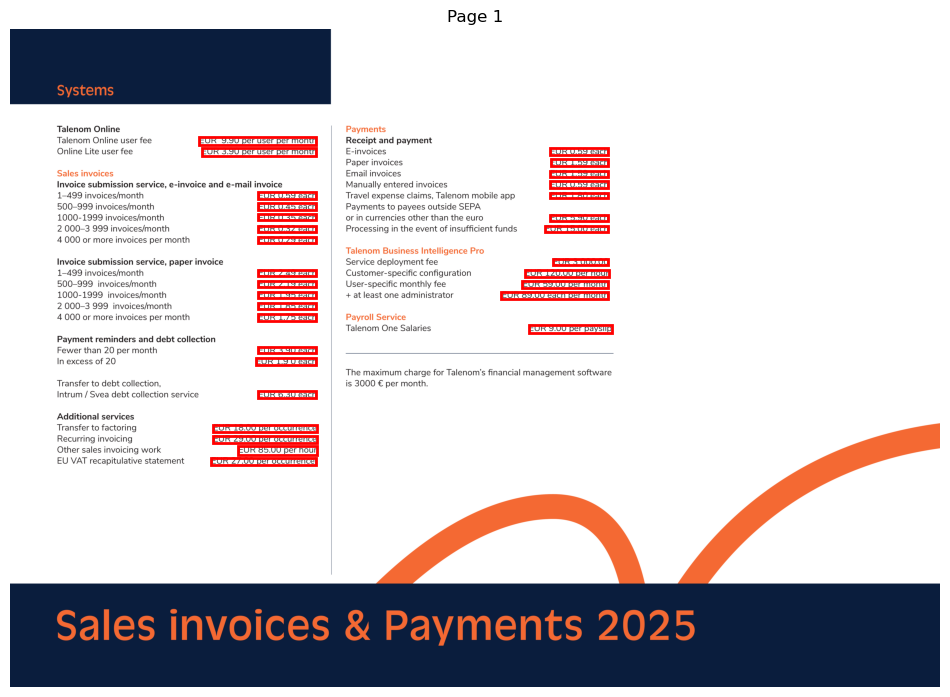

In [14]:
import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pdf2image import convert_from_path
from google.cloud import documentai_v1beta3 as documentai

# -------------------------------
# 🔹 Step 1: Convert PDF to images
# -------------------------------

pdf_path = "dataset_samples/invoice1.pdf"  # Local path to your PDF
pages = convert_from_path(pdf_path, dpi=600)

# -------------------------------
# 🔹 Step 2: Get the document response
# -------------------------------

document = result.document  # The same result from your previous process

# -------------------------------
# 🔹 Step 3: Plot each page with bounding boxes ONLY
# -------------------------------

for page_index, page in enumerate(document.pages):
    img = pages[page_index]
    fig, ax = plt.subplots(figsize=(12, 16))
    ax.imshow(img)

    # Loop through entities and draw boxes
    for entity in document.entities:
        for page_ref in entity.page_anchor.page_refs:
            if page_ref.page != page_index:
                continue  # Skip if not the same page

            # Get bounding box (normalized)
            bbox = page_ref.bounding_poly.normalized_vertices
            x_vals = [v.x for v in bbox]
            y_vals = [v.y for v in bbox]

            min_x = min(x_vals) * img.width
            min_y = min(y_vals) * img.height
            width = (max(x_vals) - min(x_vals)) * img.width
            height = (max(y_vals) - min(y_vals)) * img.height

            # Draw rectangle only (no label)
            rect = Rectangle(
                (min_x, min_y), width, height,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)

    ax.set_title(f"Page {page_index + 1}")
    plt.axis('off')
    plt.show()
